# Train TCVAE
This notebook trains a new model and saves various artifacts, such as model architecture, model weights, animations, and plots to an experiment directory in `/experiments/`.

In [1]:
import os
import sys
import argparse as ap

import git
import matplotlib.pyplot as plt

from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import (
    TerminateOnNaN, EarlyStopping, ReduceLROnPlateau, CSVLogger)

sys.path.append(git.Repo(search_parent_directories=True).working_dir)

from tcvae.models import TCVAE
from tcvae.models.square_128 import (
    make_encoder_7_convs, make_decoder_7_deconvs)
from tcvae.losses import convert_loss_dict_keys
from tcvae.data import ImageDataGenerator, crop_center_square
from tcvae.data.augmentation import *
from tcvae.utils import read_yaml, write_json, make_directory
from tcvae.callbacks import (
    ReconstructionCheck, LatentTraversalCheck, LatentDistributionLogging)
from tcvae.visualization import plot_img
# plot_loss_history, plot_dist_history

from config import EXPERIMENTS_DIR, YAML_DIR, TRAIN_DATA_DIR

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.
/opt/anaconda3/envs/tcvae/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/tcvae/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/tcvae/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/tcvae/lib/python3.7/site-pa

# Parameters
- **Saving parameters** determine what artifacts are saved and where
- **Model hyperparameters** determine model architecture
- **Training hyperparameters** determine how training proceeds
- **Logging parameters** determine what monitoring information is saved throughout training process

In [2]:
# Saving parameters
EXPERIMENT_NAME = 'test'
OVERWRITE = False

# Training hyperparameters
N_EPOCHS = 1000
BATCH_SIZE = 32

# Logging parameters
N_DIST_LOG_IMGS = 1024
N_RECON_CHECK_IMGS = 8
N_VAL_IMGS = 1024

# Setup paths

In [3]:
experiment_dir = EXPERIMENTS_DIR / EXPERIMENT_NAME
experiment_dir.mkdir(exist_ok=True, parents=True)

training_dir = experiment_dir / 'training'
training_dir.mkdir(exist_ok=True, parents=True)

recon_check_dir = training_dir / 'reconstruction-check'
recon_check_dir.mkdir(exist_ok=True, parents=True)

traversal_check_dir = training_dir / 'traversal-check'
traversal_check_dir.mkdir(exist_ok=True, parents=True)

latent_dist_history_log_file = \
    training_dir / 'latent-distribution-history.csv'
loss_history_log_file = training_dir / 'loss-history.csv'

# Load data generators
The training data generator applies random data augmentation transformations while the validation data generator does not. We use the following image data augmentation techniques:
- **RandomColorMixer**: applies random moderate contrast stretching and brightness shifting to each color channel independently. This causes image temperature and tints to change.
- **RandomIntensifier**: applies random contrast stretching and brightness shifting to entire image. This creates variations in contrast and brightness.
- **RandomFlipper**: randomly flips the image along its horizontal axis.
- **RandomSquareCropper**: crops the image to a randomly located and sized square.
- **RandomRotator**: randomly rotates the image about the center.

The order in which the augmentors are passed into the data generator matters. That is, `[f, g, h] implies f(g(h(x)))`.

In [4]:
augmentors = [
    RandomColorMixer(), RandomIntensifier(), RandomFlipper(),
    RandomSquareCropper(), RandomRotator()]
train_datagen = ImageDataGenerator(
    TRAIN_DATA_DIR, BATCH_SIZE, transformers=augmentors)
print(train_datagen, end='\n\n')

val_datagen = ImageDataGenerator(
    TRAIN_DATA_DIR, BATCH_SIZE, transformers=[crop_center_square])
print(val_datagen)

Image Data Generator
--------------------
Data path: /Users/chozhao/workspace/tcvae/data/train
Number of files: 202599
Parallelization: 16

Image Data Generator
--------------------
Data path: /Users/chozhao/workspace/tcvae/data/train
Number of files: 202599
Parallelization: 16


Let's take a peek at what augmented images look like.

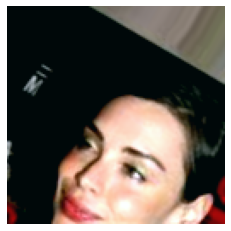

In [5]:
sample_train_img = train_datagen.load_n_images(1)[0]
plot_img(sample_train_img)

We don't need to validate on the entire un-augmented dataset. Rather, let's sample out some reasonable number of images to form the validation set.

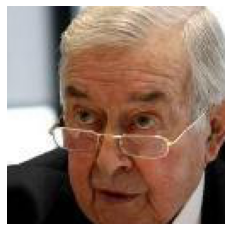

In [6]:
val_imgs = val_datagen.load_n_images(N_VAL_IMGS)
val_data = (val_imgs, val_imgs)
plot_img(val_imgs[0])

Let's also sample out some images to use for checking reconstruction and traversal quality as the model trains.

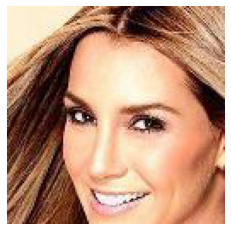

In [7]:
recon_check_imgs = val_datagen.load_n_images(N_RECON_CHECK_IMGS, random=False)
traversal_check_img = val_datagen.load_n_images(1, random=False).squeeze()
plot_img(traversal_check_img)

To log the means and variances of latent distributions, we'll want a larger number of sample images from the training set (since latent components may cover some of the axes of variation introduced through data augmentation).

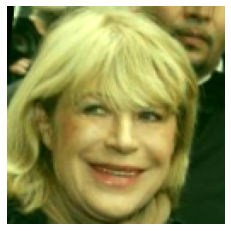

In [8]:
dist_log_imgs = train_datagen.load_n_images(1024, random=True)
plot_img(dist_log_imgs[0])

# Define callbacks

In [9]:
reconstruction_checker = ReconstructionCheck(
    recon_check_imgs, recon_check_dir)
traversal_checker = LatentTraversalCheck(
    traversal_check_img, traversal_check_dir)
dist_logger = LatentDistributionLogging(
    latent_dist_history_log_file, dist_log_imgs, verbose=True)
nan_terminator = TerminateOnNaN()
csv_logger = CSVLogger(loss_history_log_file.as_posix(), append=True)
lr_reducer = ReduceLROnPlateau(
    verbose=1, monitor='loss', factor=0.5, patience=3, min_delta=0, min_lr=1e-7)
early_stopper = EarlyStopping(
    verbose=1, restore_best_weights=True, monitor='loss', patience=10)
callbacks = [
    reconstruction_checker, traversal_checker, dist_logger,
    nan_terminator, csv_logger, lr_reducer, early_stopper]

# Define model

In [10]:
K.clear_session()
loss_dict = dict(
    kl_divergence=64,
    sigmoid_cross_entropy=0.5,
    dssim=0.5,
    mutual_information_index=0.,
    dimensional_kl=1.)
loss_dict = convert_loss_dict_keys(loss_dict)
encoder = make_encoder_7_convs(activation='elu', num_latents=64)
decoder = make_decoder_7_deconvs(activation='elu', num_latents=64)
model = TCVAE(
    encoder, decoder, loss_dict, batch_size=train_datagen.batch_size,
    dataset_size=train_datagen.n_samples)
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

kl_divergence: 64
sigmoid_cross_entropy: 0.5
dssim: 0.5
mutual_information_index: 0.0
dimensional_kl: 1.0


# Train model

In [ ]:
# model.fit_generator(train_datagen, callbacks=callbacks, epochs=N_EPOCHS)

model.fit_generator(train_datagen, epochs=N_EPOCHS)

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().
Epoch 1/1000
